This is a widget-heavy notebook that uses the nomenclature in [1] to design airfoils and analyze them.
You can analyze the vast array of airfoils in [1] by simply pasting the code of the airfoil below. Or make your own airfoil design by using the sliders.

[1] Melin, T. (2013). *Parametric Airfoil Catalog: An Aerodynamic and Geometric Comparison Between Parametrized and Point Cloud Airfoils - Part 1 and 2*.

<IPython.core.display.Javascript object>


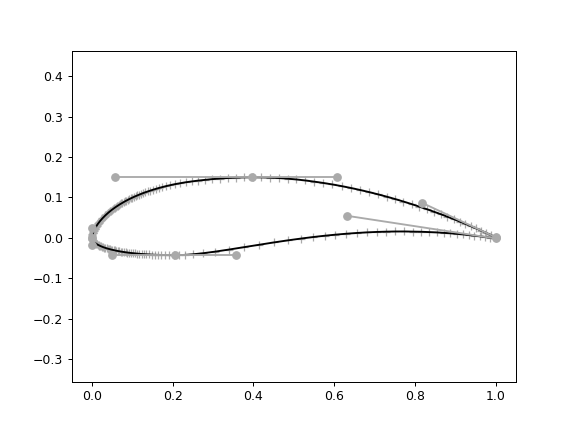

Output()

Button(description='Download Points', icon='download', style=ButtonStyle())

In [5]:
# Default to read. After running this cell this is loaded.
# Airfoil codes can be found in [1]
Airfoil = "K2ZW_awNMSkkS6I"

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

# Import airfoil designer modules
# This includes numpy, matplotlib, ...
from af_ui import * 
kparam = B64read(Airfoil)

# "global" variables, i.e. those that I want to use from within the widget-functions.
X = []
P = []

# k1 to k15 are the parameters as in [1]
ParNames = ["Nose Thck","Lead Point","Mid Point","Trail Point","Thickness",
           "Nose Thck","Lead Point","Mid Point","Trail Point","Thickness",
           "Top Len","Bottom Len","Angle Legs","Angle TE","Gap"]

# Create sliders
ks = []
for k in range(len(ParNames)):
    ks.append(FloatSlider(value = kparam[k], min=0, max=1, step=0.01, 
                          continuous_update=False,description=ParNames[k]))
# Create Plot    
fig,ax = plt.subplots(1,1)
handles = []

# Widget function
def manipulateAirfoil(k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,N,LEFAC,TEFAC,KAPFAC,
                      REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1,REFVAL):
    
    # Airfoil Coordinates
    global X,P,kparam # Set of Bezier Points, Airfoil coordinates, melin Airfoil parameters
    global fig,ax,handles # figure, axis and plot handles
     

    for kp in range(15):
        kparam[kp] = eval("k%u"%(kp+1))
    P = foilPoints(kparam)
    ds = 0.002
    (T,ArcPoints,Curvature) = pointsByArcLength(P,np.arange(0,1+ds,ds))
    (S,_,_) = getLength(P)
    
    # Airfoil Discretization
    global X # Airfoil coordinates
    global SR # Arclength discretization

    (X,SR) = repanelArclength(ArcPoints[:,::-1],int(N),LEFAC,TEFAC,KAPFAC,
                              [REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1],REFVAL)

    handles = designPlot(ax,handles,P,X)
    print("Airfoil Code:" + B64write(kparam))

# Assemble UI.

# Extra buttons
import webbrowser
def download_points(b):
    # Save discretized airfoil points, if you want
    Name = "GOE222"
    savePoints('Airfoil.dat',X,Name)
    webbrowser.open('Airfoil.dat')

DOWNPOINTS = widgets.Button(
    description='Download Points',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
    icon='download'
)

DOWNPOINTS.on_click(download_points)


paramtop = widgets.VBox([widgets.HTML(value="<u>Top Side Parameter</u>"),*ks[0:5]])
parambottom = widgets.VBox([widgets.HTML(value="<u>Bottom Side Parameter</u>"),*ks[5:10]])
paramte = widgets.VBox([widgets.HTML(value="<u>Trailing Edge Parameter</u>"),*ks[10:15]])

paramdisc = widgets.HBox([widgets.VBox([widgets.HTML(value="<u>Weights</u>"),
                                        N,KAPFAC,LEFAC,TEFAC,REFVAL]),
                          widgets.VBox([widgets.HTML(value="<u>Refinement</u>"),
                                        REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1])])
paramfoil = widgets.HBox([paramtop, parambottom,paramte])

ui = widgets.VBox([widgets.HTML(value="<b>Airfoil Parameters</b>"),paramfoil,
                   widgets.HTML(value="<b>Discretization Parameters</b>"),paramdisc])


out=widgets.interactive_output(manipulateAirfoil, {'k1':ks[0],'k2':ks[1],'k3':ks[2],'k4':ks[3],'k5':ks[4],
                                                'k6':ks[5],'k7':ks[6],'k8':ks[7],'k9':ks[8],'k10':ks[9],
                                                'k11':ks[10],'k12':ks[11],'k13':ks[12],'k14':ks[13],'k15':ks[14],
                                                'N':N,'LEFAC':LEFAC,'TEFAC':TEFAC,'KAPFAC':KAPFAC,
                                                'REFTOPX0':REFTOPX0,'REFTOPX1':REFTOPX1,
                                                'REFBOTX0':REFBOTX0,'REFBOTX1':REFBOTX1,
                                                'REFVAL':REFVAL})

# Show UI
display(ui, out)
display(DOWNPOINTS)

<IPython.core.display.Javascript object>


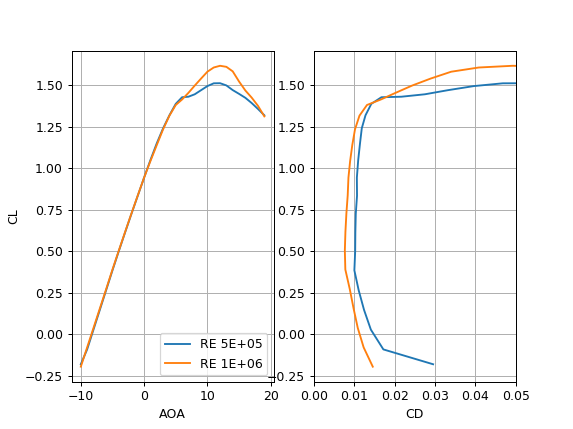

In [18]:
import webbrowser
def run_calculation(b):
    # Calculate a polar
    # You can modify the loop to include NCRIT and Mach, but stay low with the Mach number.
    
    b.description = '...'
    
    REV = [5e5,1e6]
    NCRIT = 9
    MACH = 0
    pol = []
    for RE in REV:
        (alv,clv,cdv,cmv,bl,p) = viiflowPolar(X,np.arange(-10,20,1),RE,NCRIT,MACH)
        pol.append({'AOA':alv,'CL':clv,'CD':cdv,'CM':cmv,'RE':RE,'NCRIT':NCRIT,'MA':MACH})
    
    b.description = 'Run'

def plot_polar(b):
    # Plot the polar
    (_,axp) = plt.subplots(1,2)
    for k in range(len(pol)):
        axp[0].plot(pol[k]['AOA'],pol[k]['CL'],'-',label='RE %.E'%pol[k]['RE'])
        axp[1].plot(pol[k]['CD'],pol[k]['CL'],'-')
    axp[0].legend()
    axp[1].set_xlim(0,.05)
    axp[0].grid(1)
    axp[1].grid(1)
    axp[0].set_xlabel('AOA')
    axp[0].set_ylabel('CL')
    axp[1].set_xlabel('CD');
     
def download_polar(b):
    # Save Polar data, if you want
    Name = 'GOE222'
    f = open('Polar.csv','w')
    f.close()
    f = open('Polar.csv','a')
    for k in range(len(pol)):
        # Header
        header = "%s - RE %.E - NCRIT %g - MA %g;;;\nAOA; CL; CD; CM"%(Name,pol[k]['RE'],pol[k]['NCRIT'],pol[k]['MA'])
        X = np.c_[pol[k]['AOA'],pol[k]['CL'],pol[k]['CD'],pol[k]['CM']]
        np.savetxt(f, X, fmt='%1.8f; %1.8f; %1.8f; %1.8f', newline='\n', header=header,comments='')
    f.close()
    webbrowser.open('Airfoil.dat')
DOWNPOLAR = widgets.Button(
    description='Download Polar',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
    icon='download'
)
DOWNPOLAR.on_click(download_polar)

RUN = widgets.Button(
    description='Run',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
    icon='play'
)
RUN.on_click(run_calculation)

PLOT = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
    icon='eye'
)
PLOT.on_click(plot_polar)

UIRUN = widgets.HBox([RUN,PLOT,DOWNPOLAR])
display(UIRUN)

Download polar by clicking link below.<br>
**The cell above that saves the current polar must have been executed**.

__[Polar.csv](Polar.csv)__